
# Udacity Self-Driving — Starter Notebook (Behavioral Cloning)
**What this notebook does (step-wise):**
1. Load `driving_log.csv` and images (center/left/right).  
2. Visualize sample rows & images.  
3. Preprocess images (crop, resize, normalize).  
4. Apply augmentations (flip, brightness, translation).  
5. Create a Python generator for efficient training.  
6. Build the NVIDIA CNN (end-to-end steering prediction).  
7. Train a baseline model (example config).  
8. Save the model for simulator / real-vehicle fine-tuning.

> **Files expected (already present):**
- `/mnt/data/driving_log.csv`  
- image files (e.g., `center_2025_08_27_23_00_47_235.jpg`, `left_*.jpg`, `right_*.jpg`) in `/mnt/data/`

**Notes:** This notebook is written so you can run it locally in a virtualenv. If TensorFlow / OpenCV are not installed in your environment, install them first (`pip install -r requirements.txt`).  


In [1]:
# ==========================================================
# Imports and basic configuration
# ==========================================================
import os
import math
import random
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ----------------------------------------------------------
# NOTE:
# - Heavy libraries like OpenCV (cv2) and TensorFlow 
#   will be imported later inside functions. 
#   This ensures the notebook can start even if those 
#   dependencies are not yet installed.
# ----------------------------------------------------------

# ----------------------------------------------------------
# List of all data session folders.
# Each folder is expected to contain:
#   - driving_log.csv  (with image paths and steering angles)
#   - IMG/             (subfolder containing images)
#
# Update these paths to match your dataset structure.
# ----------------------------------------------------------
LOG_DIRS = [
    Path("./session1"),
    Path("./session2"),
    Path("./session3"),
    Path("./session4"),
    Path("./session5"),
]

# ----------------------------------------------------------
# Check if sessions exist and print their contents 
# (first 10 files for quick inspection).
# ----------------------------------------------------------
print("Checking expected driving logs in these folders:\n")
for d in LOG_DIRS:
    print(f" - {d}")
    if d.exists():
        files = os.listdir(d)
        print(f"   contains {len(files)} items:", files[:10], "\n")
    else:
        print(" Folder does not exist!\n")


Checking expected driving logs in these folders:

 - session1
   contains 2 items: ['driving_log.csv', 'IMG'] 

 - session2
   contains 2 items: ['driving_log.csv', 'IMG'] 

 - session3
   contains 2 items: ['driving_log.csv', 'IMG'] 

 - session4
   contains 2 items: ['driving_log.csv', 'IMG'] 

 - session5
   contains 2 items: ['driving_log.csv', 'IMG'] 



In [2]:
# ==========================================================
# 1) Load and merge driving_log.csv from multiple sessions
# ==========================================================
import csv

dfs = []

for log_dir in LOG_DIRS:
    log_dir = Path(log_dir)
    csv_path = log_dir / "driving_log.csv"

    if not csv_path.exists():
        print(f"Skipping, no CSV found: {csv_path}")
        continue

    # ------------------------------------------------------
    # Detect separator (, ; or tab)
    # ------------------------------------------------------
    with open(csv_path, 'r', encoding='utf-8-sig', errors='ignore') as f:
        sample = f.read(2048)
        if '\t' in sample:
            sep = '\t'
        elif ';' in sample and ',' not in sample:
            sep = ';'
        else:
            sep = ','

    print(f"Detected CSV separator for {csv_path}:", repr(sep))

    # Read CSV into DataFrame
    df = pd.read_csv(csv_path, sep=sep, header=None, engine='python', na_filter=False)

    # ------------------------------------------------------
    # Standardize column names
    # Simulator log files usually have >=7 columns
    # ------------------------------------------------------
    if df.shape[1] >= 7:
        df = df.iloc[:, :7]  # keep first 7
        df.columns = ['center', 'left', 'right', 'steering', 'throttle', 'brake', 'speed']
    else:
        df.columns = [f'col{i}' for i in range(df.shape[1])]

    # ------------------------------------------------------
    # Fix image paths → ensure always from current IMG folder
    # ------------------------------------------------------
    img_dir = log_dir / "IMG"
    df["img_dir"] = img_dir  # keep reference for debugging

    for col in ['center', 'left', 'right']:
        if col in df.columns:
            df[col] = df[col].apply(lambda x: str(img_dir / Path(str(x).strip()).name))

    dfs.append(df)
    print(f"Loaded {len(df)} samples from {csv_path}")

# ----------------------------------------------------------
# Combine everything into one big DataFrame
# ----------------------------------------------------------
if not dfs:
    raise FileNotFoundError("No driving_log.csv found in provided LOG_DIRS")

df_all = pd.concat(dfs, ignore_index=True)

print("\nFinal combined dataset shape:", df_all.shape)
display(df_all.head(5))


Detected CSV separator for session1\driving_log.csv: ','
Loaded 816 samples from session1\driving_log.csv
Detected CSV separator for session2\driving_log.csv: ','
Loaded 1065 samples from session2\driving_log.csv
Detected CSV separator for session3\driving_log.csv: ','
Loaded 1097 samples from session3\driving_log.csv
Detected CSV separator for session4\driving_log.csv: ','
Loaded 1349 samples from session4\driving_log.csv
Detected CSV separator for session5\driving_log.csv: ','
Loaded 1653 samples from session5\driving_log.csv

Final combined dataset shape: (5980, 8)


,center,left,right,steering,throttle,brake,speed,img_dir
0,session1\IMG\center_2025_08_27_23_03_56_127.jpg,session1\IMG\left_2025_08_27_23_03_56_127.jpg,session1\IMG\right_2025_08_27_23_03_56_127.jpg,0.0,0.0,0.0,0.000078,session1\IMG
1,session1\IMG\center_2025_08_27_23_03_56_231.jpg,session1\IMG\left_2025_08_27_23_03_56_231.jpg,session1\IMG\right_2025_08_27_23_03_56_231.jpg,0.0,0.0,0.0,0.000078,session1\IMG
2,session1\IMG\center_2025_08_27_23_03_56_339.jpg,session1\IMG\left_2025_08_27_23_03_56_339.jpg,session1\IMG\right_2025_08_27_23_03_56_339.jpg,0.0,0.0,0.0,0.000078,session1\IMG
3,session1\IMG\center_2025_08_27_23_03_56_442.jpg,session1\IMG\left_2025_08_27_23_03_56_442.jpg,session1\IMG\right_2025_08_27_23_03_56_442.jpg,0.0,0.0,0.0,0.000080,session1\IMG
4,session1\IMG\center_2025_08_27_23_03_56_551.jpg,session1\IMG\left_2025_08_27_23_03_56_551.jpg,session1\IMG\right_2025_08_27_23_03_56_551.jpg,0.0,0.0,0.0,0.000079,session1\IMG


In [3]:
from pathlib import Path

# Helper function: Normalize image path using Path
def normalize_img_path(path, img_dir):
    """
    Normalize image path:
    - Ensure filename is joined with correct IMG folder
    - Convert to POSIX style (forward slashes)
    """
    return str(Path(img_dir) / Path(path).name).replace("\\", "/")

# Normalize all image columns
for col in ['center', 'left', 'right']:
    if col in df_all.columns:
        df_all[col] = df_all.apply(lambda row: normalize_img_path(row[col], row["img_dir"]), axis=1)

# Show sample rows to confirm
print(" Total combined rows:", len(df_all))
display(df_all.head(6))


 Total combined rows: 5980


,center,left,right,steering,throttle,brake,speed,img_dir
0,session1/IMG/center_2025_08_27_23_03_56_127.jpg,session1/IMG/left_2025_08_27_23_03_56_127.jpg,session1/IMG/right_2025_08_27_23_03_56_127.jpg,0.0,0.0,0.0,0.000078,session1\IMG
1,session1/IMG/center_2025_08_27_23_03_56_231.jpg,session1/IMG/left_2025_08_27_23_03_56_231.jpg,session1/IMG/right_2025_08_27_23_03_56_231.jpg,0.0,0.0,0.0,0.000078,session1\IMG
2,session1/IMG/center_2025_08_27_23_03_56_339.jpg,session1/IMG/left_2025_08_27_23_03_56_339.jpg,session1/IMG/right_2025_08_27_23_03_56_339.jpg,0.0,0.0,0.0,0.000078,session1\IMG
3,session1/IMG/center_2025_08_27_23_03_56_442.jpg,session1/IMG/left_2025_08_27_23_03_56_442.jpg,session1/IMG/right_2025_08_27_23_03_56_442.jpg,0.0,0.0,0.0,0.000080,session1\IMG
4,session1/IMG/center_2025_08_27_23_03_56_551.jpg,session1/IMG/left_2025_08_27_23_03_56_551.jpg,session1/IMG/right_2025_08_27_23_03_56_551.jpg,0.0,0.0,0.0,0.000079,session1\IMG
5,session1/IMG/center_2025_08_27_23_03_56_662.jpg,session1/IMG/left_2025_08_27_23_03_56_662.jpg,session1/IMG/right_2025_08_27_23_03_56_662.jpg,0.0,0.0,0.0,0.000078,session1\IMG


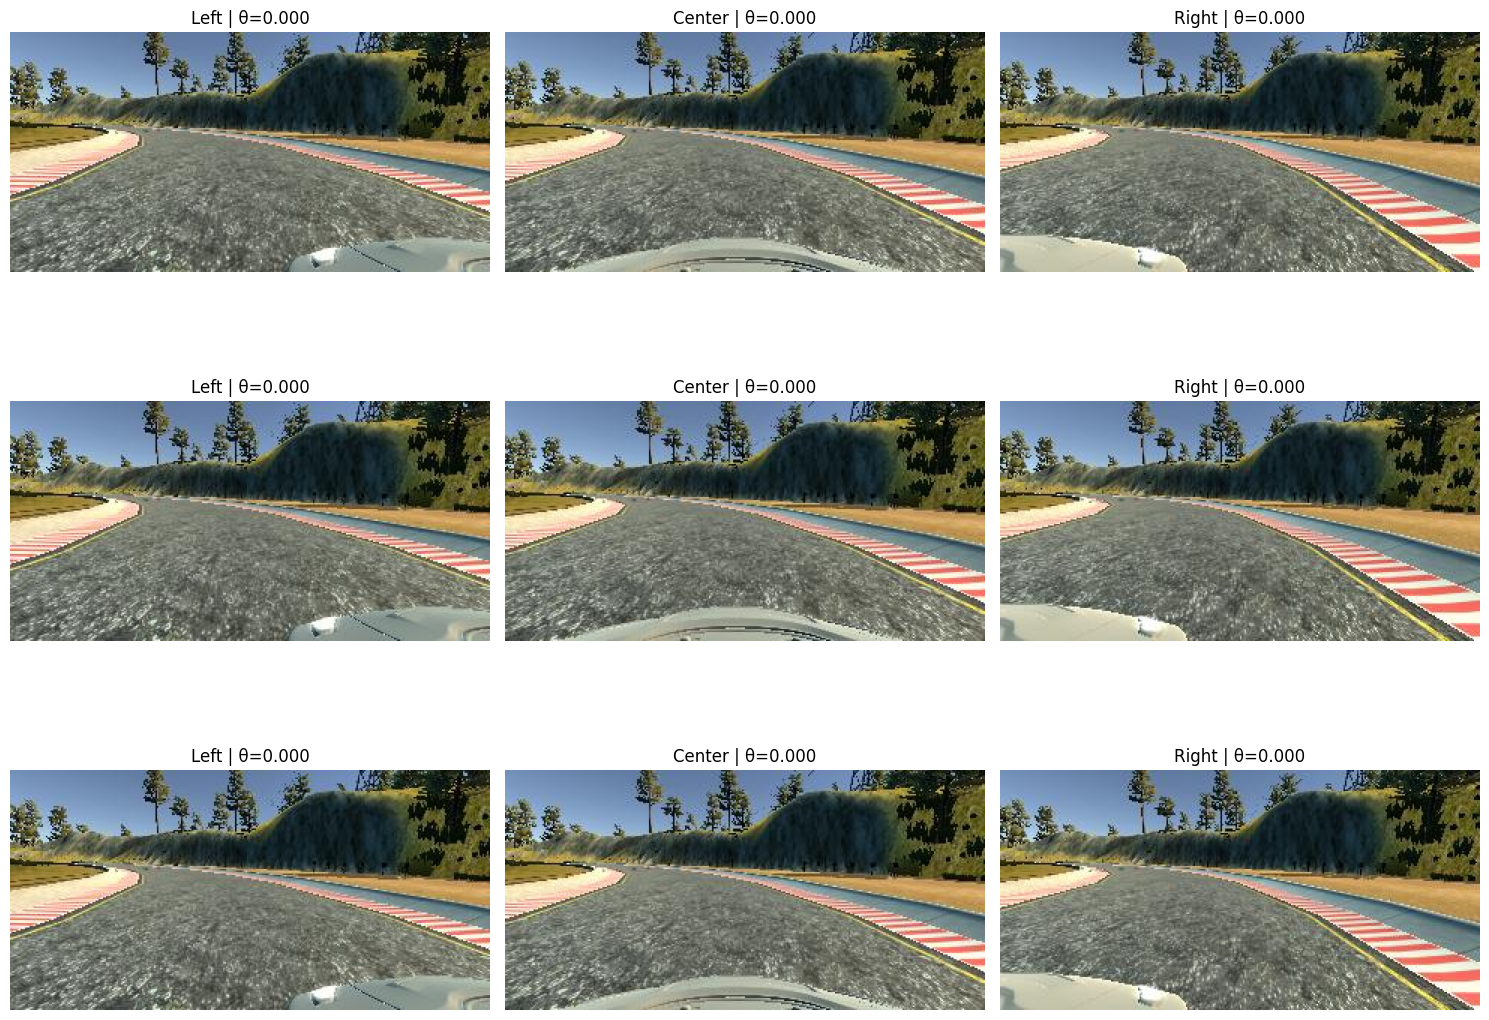

In [4]:
import cv2

def load_image(path):
    """Load an image from disk in RGB format (raise if missing)."""
    img = cv2.imread(path)
    if img is None:
        raise FileNotFoundError(f"Image not found: {path}")
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def show_sample_images(df, N=3):
    """
    Display first N samples with left, center, right images.
    """
    N = min(N, len(df))
    fig, axes = plt.subplots(N, 3, figsize=(15, 4*N))
    
    if N == 1:  # keep axes 2D always
        axes = np.expand_dims(axes, 0)
    
    for i in range(N):
        row = df.iloc[i]
        steering = float(row.get("steering", 0.0))
        titles = [f"Left | θ={steering:.3f}", 
                  f"Center | θ={steering:.3f}", 
                  f"Right | θ={steering:.3f}"]
        paths = [row["left"], row["center"], row["right"]]
        
        for j, (ax, path, title) in enumerate(zip(axes[i], paths, titles)):
            try:
                img = load_image(path)
                ax.imshow(img)
                ax.set_title(title)
            except Exception as e:
                ax.text(0.5, 0.5, str(e), ha="center", va="center", wrap=True)
            ax.axis("off")
    
    plt.tight_layout()
    plt.show()

# Show first few samples
show_sample_images(df_all, N=3)


Preprocessed image: (66, 200, 3) -0.5 0.5


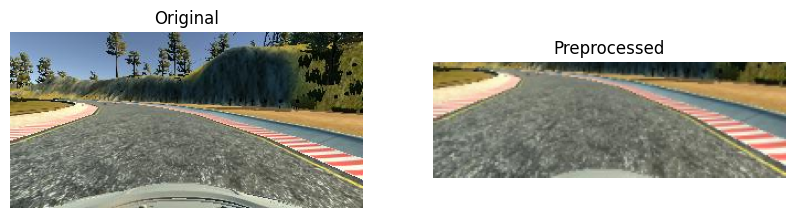

In [5]:
def preprocess_image(cv2_img, resize=(200, 66), crop_top=0.35, crop_bottom=0.1):
    """
    Preprocess an image for NVIDIA model:
    1. Convert BGR->RGB
    2. Crop top/bottom regions
    3. Resize to target shape (W,H)
    4. Normalize to [-0.5, 0.5]
    """
    import cv2
    # Ensure input is RGB
    if cv2_img.shape[2] == 3:  # safety check
        img = cv2.cvtColor(cv2_img, cv2.COLOR_BGR2RGB)
    else:
        img = cv2_img  # already RGB
    
    h, w = img.shape[:2]
    top = int(h * crop_top)
    bottom = int(h * crop_bottom)
    
    img = img[top:h-bottom, :, :]   # crop
    img = cv2.resize(img, resize, interpolation=cv2.INTER_AREA)
    img = img.astype(np.float32) / 255.0 - 0.5
    return img

# Debug visualization (only for first row)
try:
    import cv2
    sample_path = df_all['center'].iloc[0]
    raw = cv2.imread(sample_path)
    pre = preprocess_image(raw)
    print("Preprocessed image:", pre.shape, pre.min(), pre.max())

    # Show before vs after
    fig, axes = plt.subplots(1,2, figsize=(10,4))
    axes[0].imshow(cv2.cvtColor(raw, cv2.COLOR_BGR2RGB))
    axes[0].set_title("Original")
    axes[1].imshow((pre + 0.5))   # shift back to [0,1] for display
    axes[1].set_title("Preprocessed")
    for ax in axes: ax.axis("off")
    plt.show()
except Exception as e:
    print("Preprocess test failed:", e)


In [6]:
import numpy as np
import cv2
import random
from tensorflow.keras.utils import Sequence

# ---- Augmentation helpers (from before) ----
def random_flip(image, steering):
    if random.random() < 0.5:
        image = np.fliplr(image).copy()
        steering = -steering
    return image, steering

def random_brightness(image, brightness_range=(0.5, 1.5)):
    img = image + 0.5  # back to [0,1]
    hsv = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2HSV)
    factor = np.random.uniform(*brightness_range)
    hsv[:, :, 2] = np.clip(hsv[:, :, 2].astype(np.float32) * factor, 0, 255).astype(np.uint8)
    img = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB).astype(np.float32) / 255.0 - 0.5
    return img

def random_translate(image, steering, range_x=50, range_y=10, steering_correction=0.002):
    rows, cols = image.shape[:2]
    tr_x = range_x * (np.random.uniform() - 0.5)
    tr_y = range_y * (np.random.uniform() - 0.5)
    M = np.float32([[1, 0, tr_x], [0, 1, tr_y]])

    trans = cv2.warpAffine((image+0.5).astype(np.float32), M, (cols, rows), borderMode=cv2.BORDER_REPLICATE)
    trans = np.clip(trans, 0, 1) - 0.5

    steering += tr_x * steering_correction
    return trans, steering

# ---- Preprocessing ----
def preprocess_image(cv2_img, resize=(200,66)):
    img = cv2.cvtColor(cv2_img, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]
    top = int(h*0.35)   # crop sky
    bottom = int(h*0.1) # crop hood
    img = img[top:h-bottom, :, :]
    img = cv2.resize(img, resize, interpolation=cv2.INTER_AREA)
    img = img.astype('float32') / 255.0 - 0.5
    return img

# ---- Combined augmentation ----
def augment_image(image, steering):
    image, steering = random_flip(image, steering)
    if random.random() < 0.8:  # brightness with prob 0.8
        image = random_brightness(image)
    if random.random() < 0.8:  # translation with prob 0.8
        image, steering = random_translate(image, steering)
    return image, steering

# ---- Data Generator ----
class DrivingDataGenerator(Sequence):
    def __init__(self, df, batch_size=32, training=True):
        """
        df: DataFrame with columns [center, left, right, steering]
        batch_size: number of samples per batch
        training: if True, applies augmentation
        """
        self.df = df.reset_index(drop=True)
        self.batch_size = batch_size
        self.training = training
        self.steering_offset = 0.25  # offset for left/right cameras

    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))

    def __getitem__(self, idx):
        batch = self.df.iloc[idx*self.batch_size:(idx+1)*self.batch_size]

        images = []
        steerings = []

        for _, row in batch.iterrows():
            # Randomly pick center/left/right camera
            cam_choice = random.choice(["center", "left", "right"])
            img_path = row[cam_choice]
            steering = float(row["steering"])

            if cam_choice == "left":
                steering += self.steering_offset
            elif cam_choice == "right":
                steering -= self.steering_offset

            # Load & preprocess
            img = cv2.imread(img_path)
            if img is None:
                continue
            img = preprocess_image(img)

            # Apply augmentations if training
            if self.training:
                img, steering = augment_image(img, steering)

            images.append(img)
            steerings.append(steering)

        return np.array(images), np.array(steerings)


In [7]:
def generator(samples, batch_size=32, is_training=True, correction=0.2):
    num_samples = len(samples)
    while True:
        # shuffle each epoch
        samples = samples.sample(frac=1).reset_index(drop=True) if is_training else samples
        
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples.iloc[offset:offset+batch_size]
            images, steerings = [], []
            
            for _, row in batch_samples.iterrows():
                # pick center/left/right
                choice = random.choice(['center','left','right']) if is_training else 'center'
                img_path = row[choice]
                steering = float(row.get('steering', 0.0))
                
                # adjust for left/right
                if choice == 'left':
                    steering += correction
                elif choice == 'right':
                    steering -= correction
                
                # ---- Load raw image (BGR) ----
                img = cv2.imread(img_path)
                if img is None:
                    continue
                
                # ---- Preprocess first (BGR → crop, resize, normalize) ----
                img = preprocess_image(img)  # returns float [-0.5,0.5], RGB
                
                # ---- Augmentations ----
                if is_training:
                    img, steering = random_flip(img, steering)
                    img = random_brightness(img)
                    img, steering = random_translate(img, steering)
                
                images.append(img)
                steerings.append(steering)
            
            if len(images) > 0:
                yield np.array(images), np.array(steerings)


In [8]:
def build_nvidia_model(input_shape=(66,200,3)):
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Conv2D, Dense, Flatten, Dropout, Lambda
    
    model = Sequential()
    
    # If not normalized in preprocessing, use:
    # model.add(Lambda(lambda x: x / 127.5 - 1.0, input_shape=input_shape))
    model.add(Lambda(lambda x: x, input_shape=input_shape))  # identity (safe placeholder)
    
    # NVIDIA convolutional architecture
    model.add(Conv2D(24, (5,5), strides=(2,2), activation='relu'))
    model.add(Conv2D(36, (5,5), strides=(2,2), activation='relu'))
    model.add(Conv2D(48, (5,5), strides=(2,2), activation='relu'))
    model.add(Conv2D(64, (3,3), activation='relu'))
    model.add(Conv2D(64, (3,3), activation='relu'))
    
    # Fully connected layers
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1))   # regression output (steering)
    
    return model


Train samples: 1322 Validation samples: 331


C:\Users\nages\AutonomousEV\venv\lib\site-packages\keras\src\layers\core\lambda_layer.py:65: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Starting training... Steps per epoch: 41
Epoch 1/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0610
Epoch 1: val_loss improved from None to 0.03898, saving model to model_best.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - loss: 0.0622 - val_loss: 0.0390
Epoch 2/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0611
Epoch 2: val_loss did not improve from 0.03898
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 0.0599 - val_loss: 0.0420
Epoch 3/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0539
Epoch 3: val_loss did not improve from 0.03898
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.0546 - val_loss: 0.0434
Epoch 4/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0564
Epoch 4: val_loss did not improve from 0.03898
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 0.0564 - val_loss: 0.0479
Epoch 5/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0481
Epoch 5: val_loss did not improve from 0.03898
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - loss: 0.0517 - val_loss: 0.0488
Epoch 6/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0599
Epoch 6: val_loss did not improve from 0.03898
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 0.0572 - val_los

Model training complete. Saved final model to: .\model_final.h5


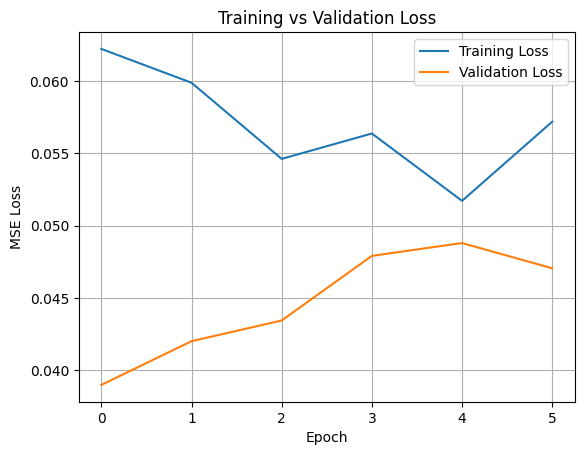

In [9]:
# ----------------------------
# Train / Validation Split
# ----------------------------
from sklearn.model_selection import train_test_split
import os

if 'steering' not in df.columns:
    df['steering'] = 0.0

train_samples, validation_samples = train_test_split(df, test_size=0.2, random_state=42)
print("Train samples:", len(train_samples), "Validation samples:", len(validation_samples))

# ----------------------------
# Training Configuration
# ----------------------------
BATCH_SIZE = 32
EPOCHS = 15

train_gen = generator(train_samples, batch_size=BATCH_SIZE, is_training=True)
valid_gen = generator(validation_samples, batch_size=BATCH_SIZE, is_training=False)

try:
    import tensorflow as tf
    from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

    model = build_nvidia_model()
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='mse')

    steps_per_epoch = max(1, len(train_samples) // BATCH_SIZE)
    validation_steps = max(1, len(validation_samples) // BATCH_SIZE)

    checkpoint = ModelCheckpoint('model_best.h5',
                                 monitor='val_loss',
                                 save_best_only=True,
                                 verbose=1)

    early_stop = EarlyStopping(monitor='val_loss',
                               patience=5,   # thoda zyada patience
                               restore_best_weights=True,
                               verbose=1)

    print("Starting training... Steps per epoch:", steps_per_epoch)

    history = model.fit(train_gen,
                        steps_per_epoch=steps_per_epoch,
                        validation_data=valid_gen,
                        validation_steps=validation_steps,
                        epochs=EPOCHS,
                        verbose=1,
                        callbacks=[checkpoint, early_stop])

    # Save final model
    model_path = os.path.join(DATA_DIR if 'DATA_DIR' in globals() else '.', 'model_final.h5')
    model.save(model_path)
    print("Model training complete. Saved final model to:", model_path)

    # Plot losses
    import matplotlib.pyplot as plt
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title('Training vs Validation Loss')
    plt.grid(True)
    plt.show()

except Exception as e:
    print("Training skipped (TensorFlow not available or other error):", e)


In [4]:
import tensorflow as tf
import os

# Path to your existing .h5 model
h5_model_path = r"C:\Users\nages\AutonomousEV\SteeringAngle\model_final.h5"

# Path where the SavedModel copy will be saved (folder path)
saved_model_dir = r"C:\Users\nages\AutonomousEV\SteeringAngle\model_final_tf"

# Load the H5 model for inference (ignore compile issues)
model = tf.keras.models.load_model(h5_model_path, safe_mode=False, compile=False)

# Export as TensorFlow SavedModel (Keras 3)
model.export(saved_model_dir)

print(f"SavedModel copy created at: {saved_model_dir}")


INFO:tensorflow:Assets written to: C:\Users\nages\AutonomousEV\SteeringAngle\model_final_tf\assets


INFO:tensorflow:Assets written to: C:\Users\nages\AutonomousEV\SteeringAngle\model_final_tf\assets


Saved artifact at 'C:\Users\nages\AutonomousEV\SteeringAngle\model_final_tf'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 66, 200, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  2349611603344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2349611608272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2349611133312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2349611650912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2349611135424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2349611648448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2349611661824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2349611660064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2349611662352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2349611814224: TensorSpec(shape=(), dtype=tf.resource, name=None


## ⚙️ How to run this notebook locally (step-by-step)

1. Create & activate your virtual environment:
- **Linux / Mac**
```bash
python3 -m venv venv
source venv/bin/activate
```
- **Windows (PowerShell)**
```powershell
python -m venv venv
.
env\Scripts\Activate.ps1
```

2. Install requirements:
```bash
pip install -r /mnt/data/requirements.txt
```

3. Start Jupyter and open the notebook:
```bash
jupyter notebook /mnt/data/self_driving_starter.ipynb
```

4. Run cells top-to-bottom. 
